In [1]:
from sklearn import metrics
import numpy as np
import scanpy as sc
from matplotlib import pyplot as plt 

from numpy.random import default_rng
rng = default_rng(seed=1234)

# Data

In [2]:
germ_sce = sc.read_h5ad("/home/ubuntu/data/germ_sce.h5ad")

In [3]:
germ_sce

AnnData object with n_obs × n_vars = 992 × 24153
    obs: 'wellKey', 'sex', 'time', 'embryo', 'sc'
    var: 'primerid'
    uns: 'X_name'
    layers: 'logcounts'

In [34]:
germ_sce.obs.time.unique().size

12

In [5]:
germ_sce.uns

{'X_name': 'tpm'}

In [28]:
sc.pp.log1p(germ_sce.X)[34,135] == germ_sce.layers["logcounts"][34,135]

False

In [29]:
## copy logcounts into X to for reproducibility, psupertime cannot yet read from "layers"
germ_copy = germ_sce.copy()
germ_copy.X = germ_sce.layers["logcounts"]

# Run PyPsupertime

In [21]:
from pypsupertime import Psupertime
from pypsupertime.model import SGDModel, CumulativePenaltySGDModel
from pypsupertime.preprocessing import transform_labels


psuper = Psupertime(preprocessing_params={"scale": True, "normalize": False, "log": True, "smooth": False, "select_genes": "hvg"},
                    estimator_class=SGDModel,
                    estimator_params={"early_stopping": False, "max_iter": 100},
                    n_jobs=5,
                    n_batches=1)

anndata = psuper.run(germ_copy.copy(), "time")

Input Data: n_genes=24153, n_cells=992
Preprocessing: done. mode='hvg', n_genes=4377, n_cells=992
Grid Search CV: CPUs=5, n_folds=5
Regularization: done   
Refit on all data: done. accuracy=0.835685.02, n_genes=4353
Total elapsed time:  0:51:52.663540


In [15]:
from pypsupertime import Psupertime
from pypsupertime.model import SGDModel, CumulativePenaltySGDModel
from pypsupertime.preprocessing import transform_labels

psuper = Psupertime(preprocessing_params={"scale": True, "normalize": False, "log": False, "smooth": False, "select_genes": "hvg"},
                    estimator_class=CumulativePenaltySGDModel,
                    estimator_params={"early_stopping": False, "max_iter": 100},
                    n_jobs=5,
                    n_batches=1)

anndata = psuper.run(germ_copy.copy(), "time")

Input Data: n_genes=24153, n_cells=992
Preprocessing: done. mode='hvg', n_genes=4377, n_cells=992
Grid Search CV: CPUs=5, n_folds=5
Regularization: done   
Refit on all data: done. accuracy=0.250000.02, n_genes=149
Total elapsed time:  0:33:06.813772


Best idx: 22 Best Score: 0.27630069539617275 Best Lambda: 0.005541020330009492 Scores std: 0.07250590078574153
1SE idx: 20 1SE Score: 0.2570732450129435 1SE Lambda: 0.008886238162743407


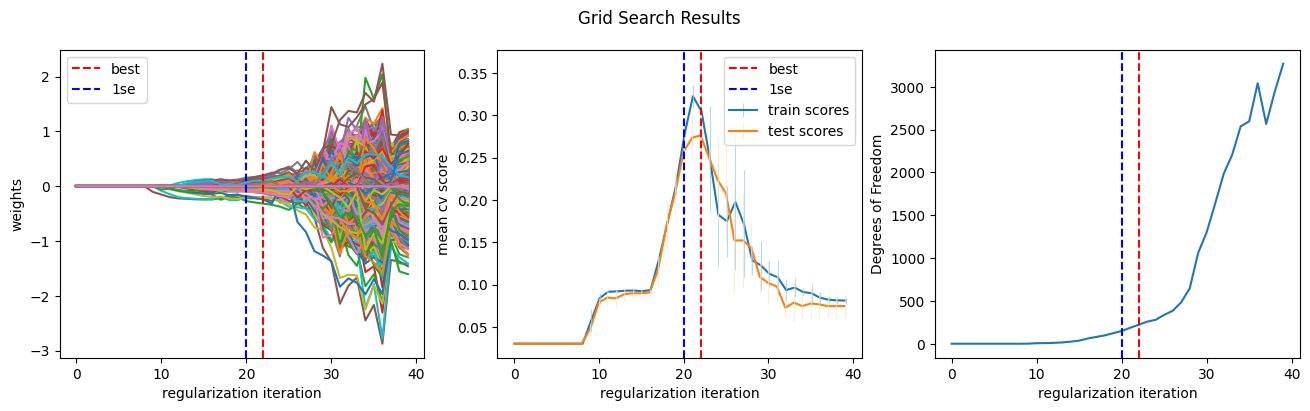

In [16]:
_ = psuper.plot_grid_search()

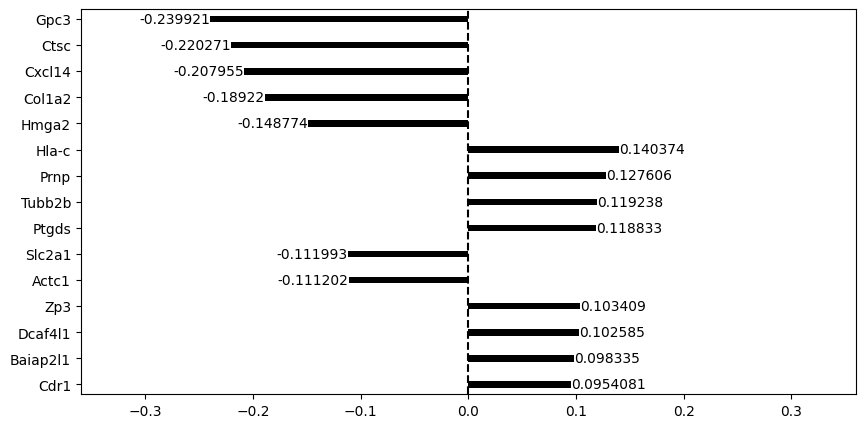

In [17]:
_ = psuper.plot_identified_gene_coefficients(anndata, n_top=15, figsize=(10,5))

Model Degrees of freedom 149
Accuracy: 0.25
Balanced accuracy: 0.22903363382086786
Mean absolute delta: 1.4557703332188763


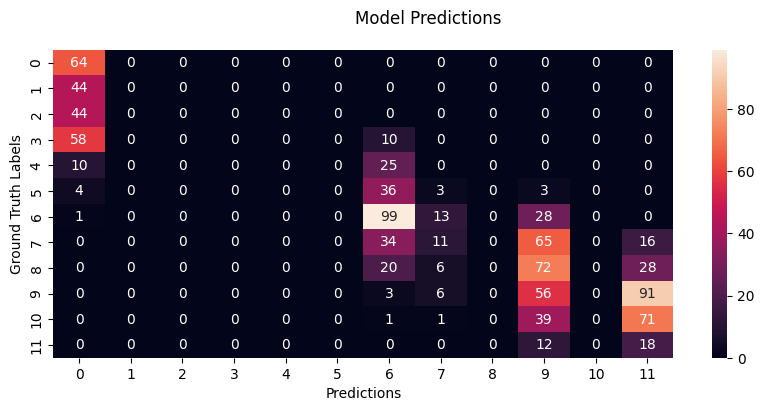

In [18]:
_ = psuper.plot_model_perf(train=(anndata.X, anndata.obs.ordinal_label))

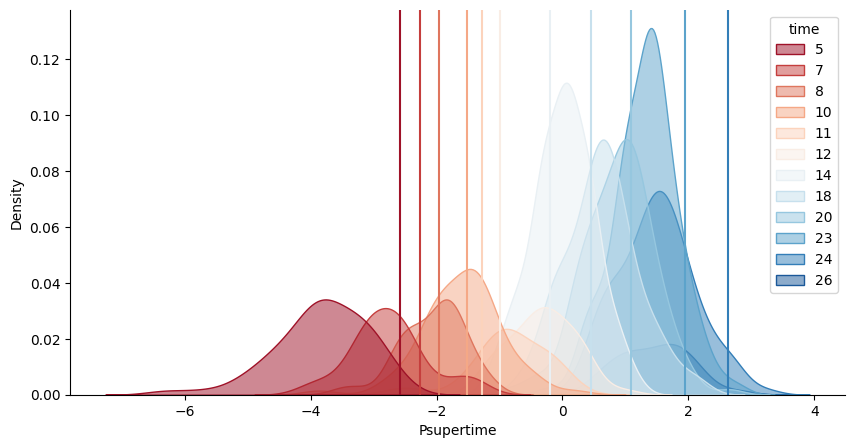

In [19]:
fig = psuper.plot_labels_over_psupertime(anndata, "time")

In [20]:
from sklearn import metrics
print("Abs Error:", metrics.mean_absolute_error(anndata.obs.ordinal_label, anndata.obs.predicted_label))
print("Balanced Acc:", metrics.balanced_accuracy_score(anndata.obs.ordinal_label, anndata.obs.predicted_label))

n_genes_start = 26178
dof =  np.count_nonzero(psuper.model.coef_)
print("DoF (sparsity): %s (%s)" % (dof, 1 - (dof / n_genes_start) ))

Abs Error: 1.3881048387096775
Balanced Acc: 0.22903363382086786
DoF (sparsity): 149 (0.994308197723279)


## Repeat on Different Seeds

In [31]:
seeds = [27, 631, 54, 42, 9]
acc_best = []
acc_1se = []
bacc_best = []
bacc_1se = []
dof_best = []
dof_1se = []

In [32]:
from pypsupertime import Psupertime
from pypsupertime.preprocessing import transform_labels
import scanpy as sc

for i, s in enumerate(seeds):
    print("Iter %i, seed %i" % (i, s))
    
    psuper = Psupertime(preprocessing_params={"scale": True, "normalize": False, "log": False, "smooth": False, "select_genes": "hvg"},
                    n_jobs=5,
                    n_batches=1,
                    random_state=s)
    adata = psuper.run(germ_copy.copy(), "time")

    acc_1se.append(metrics.accuracy_score(adata.obs.ordinal_label, adata.obs.predicted_label))
    bacc_1se.append(metrics.balanced_accuracy_score(adata.obs.ordinal_label, adata.obs.predicted_label))
    dof =  np.count_nonzero(psuper.model.coef_)
    dof_1se.append(dof)

    # refit and predict best model
    psuper.refit_and_predict(adata, "best")
    acc_best.append(metrics.accuracy_score(adata.obs.ordinal_label, adata.obs.predicted_label))
    bacc_best.append(metrics.balanced_accuracy_score(adata.obs.ordinal_label, adata.obs.predicted_label))
    dof = np.count_nonzero(psuper.model.coef_)
    dof_best.append(dof)

Iter 0, seed 27
Input Data: n_genes=24153, n_cells=992
Preprocessing: done. mode='hvg', n_genes=3876, n_cells=992
Grid Search CV: CPUs=5, n_folds=5
Regularization: done   
Refit on all data: done. accuracy=0.258065.02, n_genes=175
Total elapsed time:  0:22:43.768102
Input Data: n_genes=3876, n_cells=992
Refit on all data: done. accuracy=0.385081.02, n_genes=430
Iter 1, seed 631
Input Data: n_genes=24153, n_cells=992
Preprocessing: done. mode='hvg', n_genes=3876, n_cells=992
Grid Search CV: CPUs=5, n_folds=5
Regularization: done   
Refit on all data: done. accuracy=0.220766.02, n_genes=137
Total elapsed time:  0:22:32.333845
Input Data: n_genes=3876, n_cells=992
Refit on all data: done. accuracy=0.266129.02, n_genes=484
Iter 2, seed 54
Input Data: n_genes=24153, n_cells=992
Preprocessing: done. mode='hvg', n_genes=3876, n_cells=992
Grid Search CV: CPUs=5, n_folds=5
Regularization: done   
Refit on all data: done. accuracy=0.219758.02, n_genes=132
Total elapsed time:  0:22:24.934828
Inpu

In [36]:
import numpy as np

num_input_genes = 24153
hvg = 3876

print("1se model")
print("accuracy: %s (%s)" % (np.mean(acc_1se), np.std(acc_1se)))
print("balanced accuracy: %s (%s)" % (np.mean(bacc_1se), np.std(bacc_1se)))
print("dof: %s (%s)" % (np.mean(dof_1se) , np.std(dof_1se)))
print("Sparsity (all genes): %s (%s)" % (1- (np.mean(dof_1se) / num_input_genes), np.std(dof_1se) / num_input_genes))
print("Sparsity (hvg): %s (%s)" % (1 - (np.mean(dof_1se) / hvg), np.std(dof_1se) / hvg))
print()

print("best model")
print("accuracy: %s (%s)" % (np.mean(acc_best), np.std(acc_best)))
print("balanced accuracy: %s (%s)" % (np.mean(bacc_best), np.std(bacc_best)))
print("dof: %s (%s)" % (np.mean(dof_best) , np.std(dof_best)))
print("Sparsity (all genes): %s (%s)" % (1 - (np.mean(dof_best) / num_input_genes), np.std(dof_best) / num_input_genes))
print("Sparsity (hvg): %s (%s)" % (1 - (np.mean(dof_best) / hvg), np.std(dof_best) / hvg))

1se model
accuracy: 0.22923387096774195 (0.014518928941442605)
balanced accuracy: 0.21135667523965393 (0.010148106354070817)
dof: 142.4 (16.426807358704856)
Sparsity (all genes): 0.9941042520597856 (0.0006801145761894943)
Sparsity (hvg): 0.9632610939112487 (0.004238082393886702)

best model
accuracy: 0.3419354838709677 (0.061216663080485505)
balanced accuracy: 0.2960391445630807 (0.037504175193350024)
dof: 440.6 (37.58510343207798)
Sparsity (all genes): 0.9817579596737466 (0.0015561256751574536)
Sparsity (hvg): 0.8863261093911249 (0.009696879110443235)


## Repeat on different Seeds (all Genes)

In [46]:
seeds = [27, 631, 54, 42, 9]
acc_best = []
acc_1se = []
bacc_best = []
bacc_1se = []
dof_best = []
dof_1se = []

In [47]:
from pypsupertime import Psupertime
from pypsupertime.preprocessing import transform_labels
import scanpy as sc

for i, s in enumerate(seeds):
    print("Iter %i, seed %i" % (i, s))
    
    psuper = Psupertime(preprocessing_params={"scale": True, "normalize": False, "log": False, "smooth": False, "select_genes": "all"},
                    n_jobs=5,
                    n_batches=1,
                    random_state=s)
    adata = psuper.run(germ_copy.copy(), "time")

    acc_1se.append(metrics.accuracy_score(adata.obs.ordinal_label, adata.obs.predicted_label))
    bacc_1se.append(metrics.balanced_accuracy_score(adata.obs.ordinal_label, adata.obs.predicted_label))
    dof =  np.count_nonzero(psuper.model.coef_)
    dof_1se.append(dof)

    # refit and predict best model
    psuper.refit_and_predict(adata, "best")
    acc_best.append(metrics.accuracy_score(adata.obs.ordinal_label, adata.obs.predicted_label))
    bacc_best.append(metrics.balanced_accuracy_score(adata.obs.ordinal_label, adata.obs.predicted_label))
    dof = np.count_nonzero(psuper.model.coef_)
    dof_best.append(dof)

Iter 0, seed 27
Input Data: n_genes=24153, n_cells=992
Preprocessing: done. mode='all', n_genes=18345, n_cells=992
Grid Search CV: CPUs=5, n_folds=5
Regularization: done   
Refit on all data: done. accuracy=0.295363.02, n_genes=198
Total elapsed time:  2:01:21.487936
Input Data: n_genes=18345, n_cells=992
Refit on all data: done. accuracy=0.279234.02, n_genes=234
Iter 1, seed 631
Input Data: n_genes=24153, n_cells=992
Preprocessing: done. mode='all', n_genes=18345, n_cells=992
Grid Search CV: CPUs=5, n_folds=5
Regularization: done   
Refit on all data: done. accuracy=0.227823.02, n_genes=157
Total elapsed time:  1:45:53.520061
Input Data: n_genes=18345, n_cells=992
Refit on all data: done. accuracy=0.285282.02, n_genes=241
Iter 2, seed 54
Input Data: n_genes=24153, n_cells=992
Preprocessing: done. mode='all', n_genes=18345, n_cells=992
Grid Search CV: CPUs=5, n_folds=5
Regularization: done   
Refit on all data: done. accuracy=0.266129.02, n_genes=193
Total elapsed time:  1:45:28.050061

In [49]:
import numpy as np

def latex_tabular_fmt(acc, dof, n):
    acc_mean = np.round(np.mean(acc) * 100, 2)
    sparsity_mean = np.round((1 - (np.mean(dof) / n)) * 100, 2)
    acc_std = np.round(np.std(acc) * 100, 1)
    sparsity_std = np.round((np.std(dof) / n) * 100, 1)

    latex_template = "$%s \\pm %s$  &  $%s \\pm %s$"
    return latex_template % (acc_mean, acc_std, sparsity_mean, sparsity_std)

num_input_genes = 18345

print("1se model")
print("accuracy: %s (%s)" % (np.mean(acc_1se), np.std(acc_1se)))
print("balanced accuracy: %s (%s)" % (np.mean(bacc_1se), np.std(bacc_1se)))
print("dof: %s (%s)" % (np.mean(dof_1se) , np.std(dof_1se)))
print("Sparsity (all genes): %s (%s)" % (1 - (np.mean(dof_1se) / num_input_genes), np.std(dof_1se) / num_input_genes))
print("LATEX: accuracy & sparsity \\\\")
print(latex_tabular_fmt(acc_1se, dof_1se, num_input_genes))
print()

print("best model")
print("accuracy: %s (%s)" % (np.mean(acc_best), np.std(acc_best)))
print("balanced accuracy: %s (%s)" % (np.mean(bacc_best), np.std(bacc_best)))
print("dof: %s (%s)" % (np.mean(dof_best) , np.std(dof_best)))
print("Sparsity (all genes): %s (%s)" % (1 - (np.mean(dof_best) / num_input_genes), np.std(dof_best) / num_input_genes))
print("LATEX: accuracy & sparsity \\\\")
print(latex_tabular_fmt(acc_best, dof_best, num_input_genes))


1se model
accuracy: 0.2695564516129032 (0.025274893458411)
balanced accuracy: 0.26448761246633584 (0.013440570433809279)
dof: 187.4 (15.291827882892221)
Sparsity (all genes): 0.9897846824747888 (0.0008335692495444111)
LATEX: accuracy & sparsity \\
$26.96 \pm 2.5$  &  $98.98 \pm 0.1$

best model
accuracy: 0.30564516129032254 (0.025473533019495297)
balanced accuracy: 0.2736779630928567 (0.0188149405456059)
dof: 237.2 (3.867815921162743)
Sparsity (all genes): 0.987070046334151 (0.00021083760813097536)
LATEX: accuracy & sparsity \\
$30.56 \pm 2.5$  &  $98.71 \pm 0.0$
